# Supervised Learning

Resumen de sección: En esta sección de Aprendizaje Supervisado, se explora la aplicación del Gaussian Processes Regression, para la predicción de emisiones de CO2. Se tomó como inspiración el artículo *Can Machine Learning be Applied to Carbon Emissions Analysis: An Application to the CO2 Emissions Analysis Using Gaussian Process Regression* de Ning Ma, Wai Yan Shum y Tingting Han. Los resultados arrojan un R2 de 73% aprox, sin embargo destaca una serie de valores cuya predicción se opta por la media de la distribución (250), lo cual resulta particular. Se comparan distintas métricas como *MAE, MSE, RMSE y MAPE* contra las predicciones de una regresión lineal múltiple. La RLM resulta con mejor performance en general.

In [1]:
# lectura de datos
import pandas as pd
df = pd.read_csv('C:/Users/emanuel.novelo/Desktop/MCD - 2024-2026/ML - 2do Tetra/MCD----ML----2024/data/CO2 Emissions_Canada.csv')
# filtrando columnas numéricas

In [2]:
features = df[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)',
                 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 
                 'Fuel Consumption Comb (mpg)']]


In [3]:
X = features
y = df[['CO2 Emissions(g/km)']]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Exploración previa

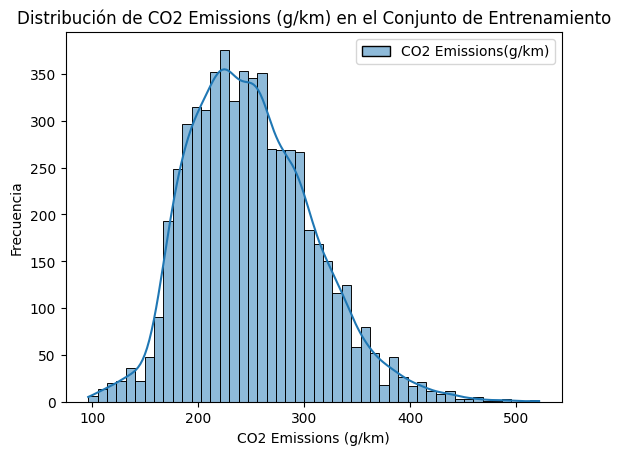

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_train, kde=True)
plt.title('Distribución de CO2 Emissions (g/km) en el Conjunto de Entrenamiento')
plt.xlabel('CO2 Emissions (g/km)')
plt.ylabel('Frecuencia')
plt.show()

De la gráfica anterior de emisiones, se observa como la media de los datos se acerca al valor 250, esto tomará peso en los siguientes resultados.

## Resultados & Conclusiones

Se entrena un modelo de un Proceso de Regresión Gaussiano, el cuál ha sido probado previamente en la literatura como un buen predictor de emisiones de CO2.

In [11]:
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel, random_state=0)
model.fit(X_train, y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)
y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)

C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Text(0, 0.5, 'Predicted')

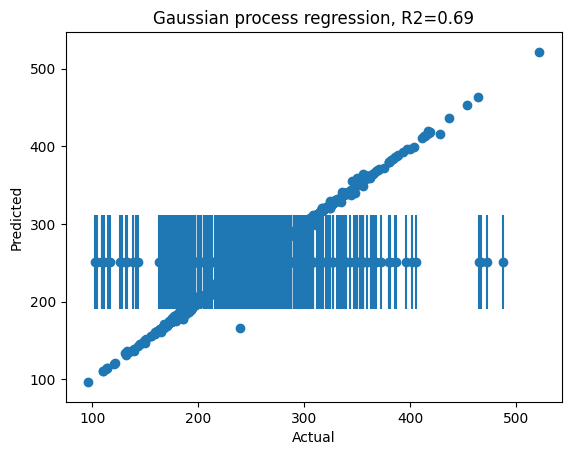

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')

Los resultados del modelo indican un ajuste de 73% sobre los datos predichos vs observados, sin embargo se destaca una serie de predicciones que resultaron en la media de la distribución, de alrededor de 250, comparado contra las observaciones reales se puede percibir una recta horizontal, se discutirá más adelante en este paper las posibles causas.

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
y_test_np = y_test.to_numpy().flatten()
y_pred_te_np = y_pred_te.flatten()

# Calcular las métricas
mae = mean_absolute_error(y_test_np, y_pred_te_np)
mse = mean_squared_error(y_test_np, y_pred_te_np)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_np - y_pred_te_np) / y_test_np)) * 100

# Crear DataFrame con las métricas
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Value': [mae, mse, rmse, mape]
})
metrics_df

,Metric,Value
0,MAE,13.908890
1,MSE,1049.595387
2,RMSE,32.397460
3,MAPE,5.967524


Se muestran las métricas de desempeño, los resultados per se podrían decirse no tan negativos, sin embargo es preferible que sean comparados con observaciones similares y resultados de métricas de la literatura.

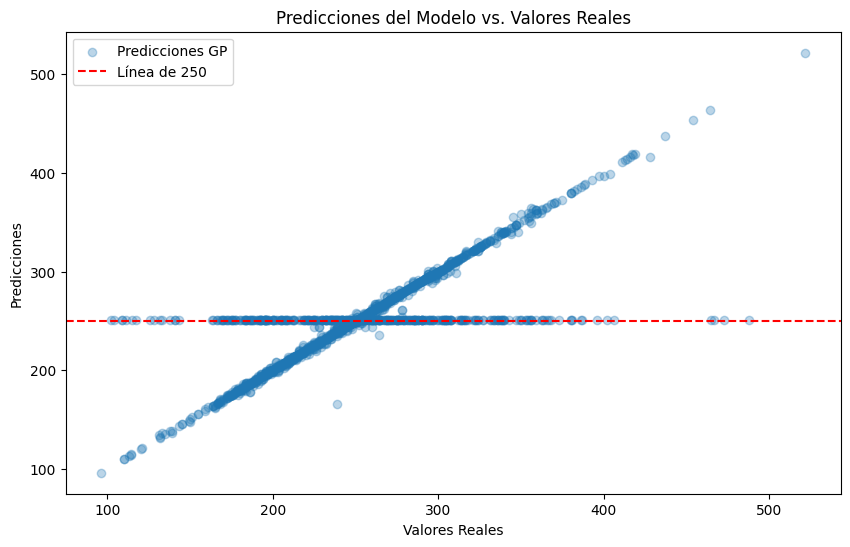

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_te, alpha=0.3, label='Predicciones GP')
plt.axhline(y=250, color='r', linestyle='--', label='Línea de 250')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones del Modelo vs. Valores Reales')
plt.legend()
plt.show()

In [15]:
correlations = features.corrwith(df['CO2 Emissions(g/km)'])
print(correlations)

Engine Size(L)                      0.851145
Cylinders                           0.832644
Fuel Consumption City (L/100 km)    0.919592
Fuel Consumption Hwy (L/100 km)     0.883536
Fuel Consumption Comb (L/100 km)    0.918052
Fuel Consumption Comb (mpg)        -0.907426
dtype: float64


Se muestran las correlaciones. las cuales muestran  fuerte relación de las variables numéricas hacia el resultado a predecir, que es la emisión de CO2.

  Metric  Linear Regression  Gaussian Process
0    MAE          11.730498         13.908890
1    MSE         353.567732       1049.595387
2   RMSE          18.803397         32.397460
3   MAPE           4.587831          5.967524
4     R2           0.895123          0.688664


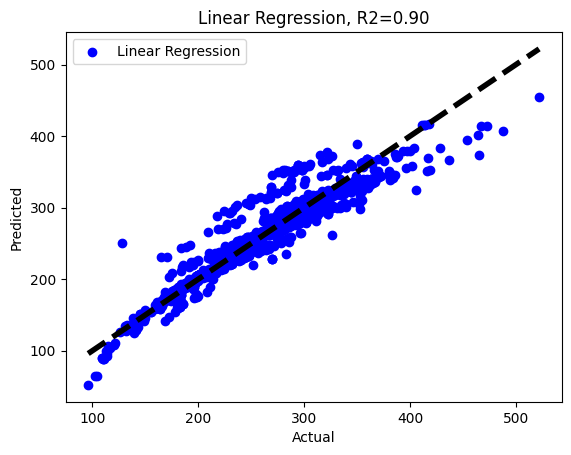

In [17]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# predecir
y_pred_linear = linear_model.predict(X_test)

# calcular métricas para regresión lineal
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mape_linear = np.mean(np.abs((y_test.to_numpy().flatten() - y_pred_linear.flatten()) / y_test.to_numpy().flatten())) * 100
r2_linear = r2_score(y_test, y_pred_linear)

# crear DataFrame con las métricas para regresión lineal
metrics_linear_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE', 'R2'],
    'Linear Regression': [mae_linear, mse_linear, rmse_linear, mape_linear, r2_linear]
})

# crear DataFrame con las métricas para regresión gaussiana
metrics_gp_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE', 'R2'],
    'Gaussian Process': [mae, mse, rmse, mape, r2_score(y_test_np, y_pred_te_np)]
})

# combinar los DataFrames para comparación
comparison_df = pd.merge(metrics_linear_df, metrics_gp_df, on='Metric')
print(comparison_df)

# visualizar las predicciones de la regresión lineal múltiple
plt.figure()
plt.scatter(y_test, y_pred_linear, color='blue', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression, R2=%.2f' % r2_linear)
plt.legend()
plt.show()

Se comparan los resultados de perfromance del GPR vs una Regresión Lineal Múltiple, para connotar que en este caso particular, un modelo más avanzado no resulta necesariamente mejor que la estadística tradicional, sin embargo, cabe destacar y dejar muy claro que no se realizaron esfuerzos de hyperparameter tunning, feature engineering, dimensionality reduction, ni parameter optimization, que pudieran resultar en un performance de índole superior a favor del modelo GPR.

### Diseño de Experimentos

Se realiza una optimización de Hipermarametros para el modelo de regresión gaussiana con el fin de mejorar el rendimiento del modelo. Finalmente se vuelve a comparar con la Regresión Lineal Múltiple.

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, DotProduct
import numpy as np

X_tr = np.array(X_train)
y_tr = np.array(y_train)

param_grid = [{
    "alpha":  [1e-2, 1e-3],
    "kernel": [RBF(l) for l in np.logspace(-1, 1, 2)]
}, {
    "alpha":  [1e-2, 1e-3],
    "kernel": [DotProduct(sigma_0) for sigma_0 in np.logspace(-1, 1, 2)]
}]

# scores for regression
scores = ['explained_variance', 'r2']

gp = GaussianProcessRegressor()
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(estimator=gp, param_grid=param_grid, cv=4, scoring='%s' % score)
    # Reshape X_tr only if it's 1-dimensional
    if X_tr.ndim == 1:
        X_tr = X_tr.reshape(-1, 1)
    clf.fit(X_tr, y_tr)
    print(clf.best_params_)

# Tuning hyper-parameters for explained_variance



C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: C

{'alpha': 0.01, 'kernel': RBF(length_scale=10)}
# Tuning hyper-parameters for r2



C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: C

{'alpha': 0.01, 'kernel': RBF(length_scale=10)}


In [22]:
# Predict on the test data
X_te = np.array(X_test)
y_te = np.array(y_test)

y_pred = clf.predict(X_te)

Se muestra a continuación los resultados de la predicción vs las observaciones actuales en un Scatterplot. Finalmente se muestran los resultados con las métricas de desempeño previamente empleadas.

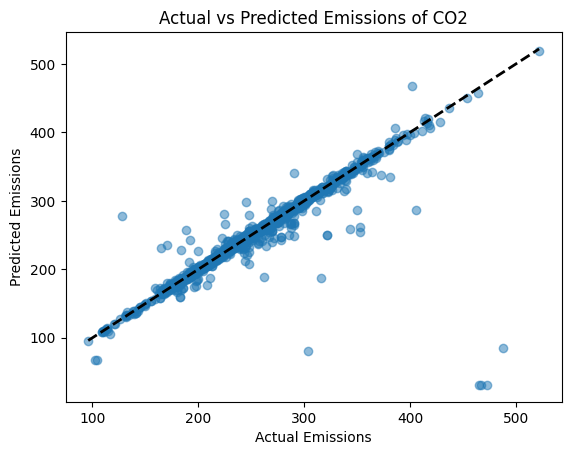

In [23]:
# Plotting
plt.scatter(y_te, y_pred, alpha=0.5)
plt.xlabel("Actual Emissions")
plt.ylabel("Predicted Emissions")
plt.title("Actual vs Predicted Emissions of CO2")
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'k--', lw=2)
plt.show()

In [25]:
# Calculate metrics
mae = mean_absolute_error(y_te, y_pred)
mse = mean_squared_error(y_te, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_te - y_pred) / y_te)) * 100
r2 = r2_score(y_te, y_pred)

# Print metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R2: {r2}")

MAE: 5.748593839203
MSE: 657.4599804086429
RMSE: 25.64098243844496
MAPE: 27.084351647188402%
R2: 0.8049810000564228


En los resultados de las métricas se puede observar una mejora significativa respecto al primer modelo base de GPR. Salvo por el MAE, en general el modelo de Regresión Lineal Múltiple conservó mejores resultados de error. A través del diseño de experimentos, el modelo tomó aproximadamente seis veces más de tiempo de entrenamiento que el modelo base (30 vs 5 mins).

In [ ]:
# borrar esta seccionNA

## Bibliografía de la sección

- https://www.frontiersin.org/articles/10.3389/fenrg.2021.756311/full
- https://towardsdatascience.com/getting-started-with-gaussian-process-regression-modeling-47e7982b534d